In [1]:
import pandas as pd
import re
import math
import time
import random
import matplotlib.pyplot as plt
import numpy as np

from deap import algorithms, base, creator, tools

In [2]:
# TSPLIB file reader
def read_tsplib_file(filename):
    if filename is None:
        raise FileNotFoundError('Filename can not be None')
    with open(filename) as file:
        lines = file.readlines()
        data = [line.lstrip() for line in lines if line != ""]
        dimension = re.compile(r'[^\d]+')
        for item in data:
            if item.startswith('DIMENSION'):
                dimension = int(dimension.sub('', item))
                break
        c = [-1.0] * (2 * dimension)
        cities_coord = []
        for item in data:
            if item[0].isdigit():
                j, coordX, coordY = [float(x.strip()) for x in item.split(' ')]
                c[2 * (int(j) - 1)] = coordX
                c[2 * (int(j) - 1) + 1] = coordY
                cities_coord.append([coordX, coordY])
        cities = pd.DataFrame(cities_coord)
        #         cities = cities_coord
        matrix = [[-1] * dimension for _ in range(dimension)]
        for k in range(dimension):
            matrix[k][k] = 0
            for j in range(k + 1, dimension):
                dist = math.sqrt((c[k * 2] - c[j * 2]) ** 2 + (c[k * 2 + 1] - c[j * 2 + 1]) ** 2)
                dist = round(dist)
                matrix[k][j] = dist
                matrix[j][k] = dist
        return matrix, dimension, cities

In [3]:
def create_clusters(X):
    from sklearn.cluster import KMeans
    clusters = int(math.sqrt(len(X))+0.5)
    km = KMeans(
        n_clusters=clusters, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    y = km.fit_predict(X)
    kc = km.cluster_centers_
    return y,kc

In [4]:
def evalTSP(individual, dist_mat):
    distance = dist_mat[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_mat[gene1][gene2]
    return distance,

In [5]:
def create_toolbox_cluster(num_cities, ind_mutpb, tourn_size, matrix):
    tb = base.Toolbox()
    tb.register("indices", np.random.permutation, num_cities)
    tb.register("individual", tools.initIterate, creator.Individual, tb.indices)
    tb.register("population", tools.initRepeat, list, tb.individual)
    tb.register("mate", tools.cxOrdered)
    tb.register("mutate", tools.mutShuffleIndexes, indpb=ind_mutpb) 
    tb.register("select", tools.selTournament, tournsize=tourn_size) 
    tb.register("evaluate", evalTSP, dist_mat=matrix)
    return tb

In [6]:
def create_toolbox_global(num_cities, ind_mutpb, tourn_size, matrix, clusterpath):
    tb = base.Toolbox()
    tb.register("indices", create_individual, kpath=clusterpath)
    tb.register("individual", tools.initIterate, creator.Individual, tb.indices)
    tb.register("population", tools.initRepeat, list, tb.individual)
    tb.register("mate", tools.cxOrdered)
    tb.register("mutate", tools.mutShuffleIndexes, indpb=ind_mutpb) 
    tb.register("select", tools.selTournament, tournsize=tourn_size) 
    tb.register("evaluate", evalTSP, dist_mat=matrix)
    return tb

In [7]:
def create_individual(kpath):
    indiv = []
    for k in kpath:
        if k != 'centers':
            seq = np.asarray(kpath[k])
            seqmod = np.roll(seq,random.randint(0,seq.shape[0]))
            indiv.extend(seqmod.tolist())
#     print(indiv)
    return indiv

In [8]:
def create_stats():
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('min', np.min)
    return stats

In [9]:
def create_dist_mat(cityList):
    dimension = cityList.shape[0]
    matrix = [[-1] * dimension for _ in range(dimension)]
    for k in range(dimension):
        matrix[k][k] = 0
        for j in range(k + 1, dimension):
            dist = math.sqrt((cityList[k,0] - cityList[j,0]) ** 2 + (cityList[k,1] - cityList[j,1]) ** 2)
            dist = round(dist)
            matrix[k][j] = dist
            matrix[j][k] = dist
    return matrix

In [10]:
# solve partial tsp for each cluster

def ga_cluster(citylist,citiesidx):
    m0 = create_dist_mat(citylist)
    l0 = citylist.shape[0]
    pop_size = 4*l0
    nb_generations = 200
    cross_prob = 0.85        
    mut_prob = 0.2          
    toolbox = create_toolbox_cluster(num_cities=l0, ind_mutpb=1/l0 , tourn_size=3, matrix=m0)
#     random.seed(37)
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    result, log = algorithms.eaSimple(pop, 
                                      toolbox, 
                                      cxpb=cross_prob, 
                                      mutpb=mut_prob, 
                                      ngen=nb_generations, 
                                      verbose=False,  
                                      halloffame=hof)
    
    fitness = evalTSP(hof[0], m0)[0]
    hof_idx = [citiesidx[x] for x in hof[0]]
    n_evals = sum([x['nevals'] for x in log])
    return hof_idx, n_evals

In [11]:
#  function to make print report of function solving

def print_solution(res, log, duration, nevaltot, t_tot):
    solution_x = res[0]
    fitness = evalTSP(solution_x,dist_matrix)[0]
    n_evals = sum([x['nevals'] for x in log])
    nb_gen = len(log)-1
    print('-' *60)
    print("Function: %s" % problem_name)
    print("Problem dimension: %d" % nb_cities)
    print("Global Optimum: %d" % optimal_fitness)
    print('-' *60)
    print("Algorithm: %s" % algorithm_name)
    print("Parameters:")
    for p in params:
        print("\t%s: " % p ,params[p] )
    print('-' *60)
    print("Fitness: %d" % fitness)
    print("Solution: ")
    print(solution_x)
    print('-' *60)
    print("Nb of function evaluations: %d" % n_evals)
    print("Stopping criterion: after %d generations" % nb_gen)
    print("computational time: %.3f seconds" % duration)

    plt.plot(log.select('min'), 'c-')
    plt.ylabel('Fitness');
    plt.xlabel('Generations');
    plt.show()
    
    print("Overall (including clusters evalutations):")
    print("nb of function evaluations: %d" % nevaltot)
    print("computational time: %.3f seconds" % t_tot)

In [12]:
def plot_result(individual=[], plot_cities=True, plot_cent_path=True, plot_clust_path=True, plot_individual=True ):

    plt.figure(figsize=(12,12))
    # plot cities
    if plot_cities:
        for k in range(np.unique(Klusters).shape[0]):
            plt.scatter(cities_coord[Klusters==k][0],cities_coord[Klusters==k][1])
    # plot sub cluster paths
    for solution in paths:
        xlist=[]
        ylist=[]
        if solution=='centers':
            if plot_cent_path:
                # centroids path
                xlist = [Kcenters[i,0] for i in paths[solution]]
                ylist = [Kcenters[i,1] for i in paths[solution]]
                col='black'
                ls='--'
                mark='*'
        else:
            if plot_clust_path:
                # each cluster path
                xlist = [cities_coord.iloc[i,0] for i in paths[solution]]
                ylist = [cities_coord.iloc[i,1] for i in paths[solution]]
                col='red'
                ls='dotted'
                mark=''
        if len(xlist) > 0:
            xlist.append(xlist[0])
            ylist.append(ylist[0])
            plt.plot(xlist, ylist, linestyle=ls,c=col,marker=mark)
    if plot_individual and len(individual)>0:
        # plot solution    
        xlist = [cities_coord.iloc[i,0] for i in individual]
        ylist = [cities_coord.iloc[i,1] for i in individual]
        xlist.append(xlist[0])
        ylist.append(ylist[0])
        plt.plot(xlist, ylist, linestyle='-')

    plt.axis('scaled')
    plt.show()

In [13]:
# Create Deap problem

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, typecode='i', fitness=creator.FitnessMin)

neval_total = 0
comp_time_tot = 0

In [14]:
# TSP definition

problem_name = 'Qatar 194 TSP'
optimal_fitness = 9352
dist_matrix, nb_cities, cities_coord = read_tsplib_file('./qa194.tsp')

In [15]:
# Split into clusters

Klusters, Kcenters = create_clusters(cities_coord)

# Run TSP for each cluster

paths = {}
t1 = time.time()
paths['centers'], nev = ga_cluster(Kcenters,[i for i in range(Kcenters.shape[0])])
t2 = time.time()
neval_total += nev
comp_time_tot += t2 - t1

for c in paths['centers']:
    citiesindex = cities_coord[Klusters==c].index.values
    newcitylist = cities_coord[Klusters==c].to_numpy()
    t1 = time.time()
    paths[c], nev = ga_cluster(newcitylist,citiesindex)
    t2 = time.time()
    neval_total += nev
    comp_time_tot += t2 - t1

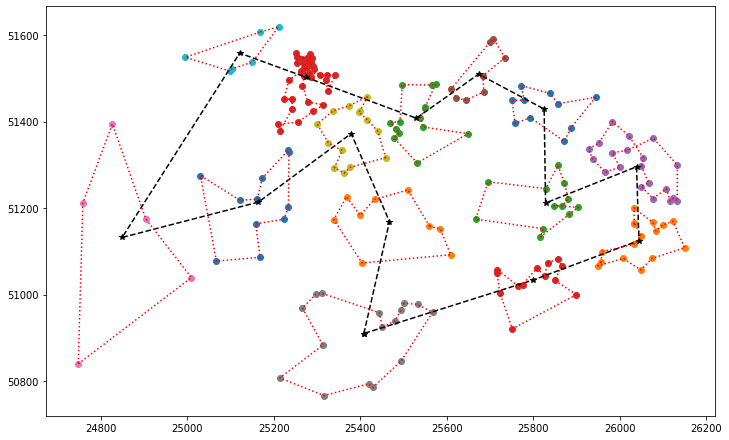

In [16]:
plot_result(plot_cities=True,plot_cent_path=True,plot_clust_path=True,plot_individual=False)

In [17]:
# define algorithm parameters

algorithm_name = "Simple Evolutionary Algorithm"

pop_size = 500
nb_generations = 1000
cross_prob = 0.85

mut_prob = 0.08
indep_mut_prob = 1/nb_cities

tournament_size = 4

params = {"Population Size": pop_size, 
          "Nb of generations": nb_generations,
          "Crossover probability": cross_prob, 
          "Mutation Probability": mut_prob, 
          "Indep. gene mut prob": round(indep_mut_prob, 3),
          "Tournament size": tournament_size
         }

In [18]:
# instantiate problem to solve

toolbox = create_toolbox_global(nb_cities, ind_mutpb=indep_mut_prob, tourn_size=tournament_size, matrix=dist_matrix, clusterpath=paths)
fit_stats = create_stats()
hof = tools.HallOfFame(1)

In [19]:
# run algorithm and print solution

t1 = time.time()
result, log = algorithms.eaSimple(toolbox.population(n=pop_size), 
                                  toolbox, 
                                  cxpb=cross_prob, 
                                  mutpb=mut_prob, 
                                  ngen=nb_generations, 
                                  verbose=False, 
                                  stats=fit_stats,
                                  halloffame=hof)
t2 = time.time()
neval_total += sum([x['nevals'] for x in log])
comp_time_tot += t2 - t1

------------------------------------------------------------
Function: Qatar 194 TSP
Problem dimension: 194
Global Optimum: 9352
------------------------------------------------------------
Algorithm: Simple Evolutionary Algorithm
Parameters:
	Population Size:  500
	Nb of generations:  1000
	Crossover probability:  0.85
	Mutation Probability:  0.08
	Indep. gene mut prob:  0.005
	Tournament size:  4
------------------------------------------------------------
Fitness: 10711
Solution: 
[29, 31, 30, 39, 42, 37, 34, 41, 48, 49, 54, 43, 40, 45, 47, 53, 51, 52, 55, 57, 60, 65, 72, 66, 50, 46, 38, 33, 26, 21, 28, 27, 20, 17, 32, 56, 63, 44, 36, 67, 99, 96, 91, 94, 95, 92, 102, 117, 105, 104, 106, 107, 111, 109, 114, 115, 116, 120, 119, 122, 123, 127, 132, 128, 130, 135, 134, 142, 147, 159, 154, 150, 146, 140, 121, 118, 138, 137, 153, 156, 149, 143, 152, 151, 158, 157, 161, 165, 170, 179, 177, 180, 176, 183, 187, 188, 190, 191, 192, 184, 169, 166, 167, 164, 174, 178, 171, 168, 175, 181, 193, 1

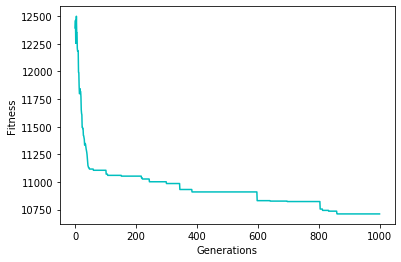

Overall (including clusters evalutations):
nb of function evaluations: 578428
computational time: 86.163 seconds


In [20]:
print_solution(res=hof, log=log, duration=t2-t1, nevaltot=neval_total, t_tot=comp_time_tot)

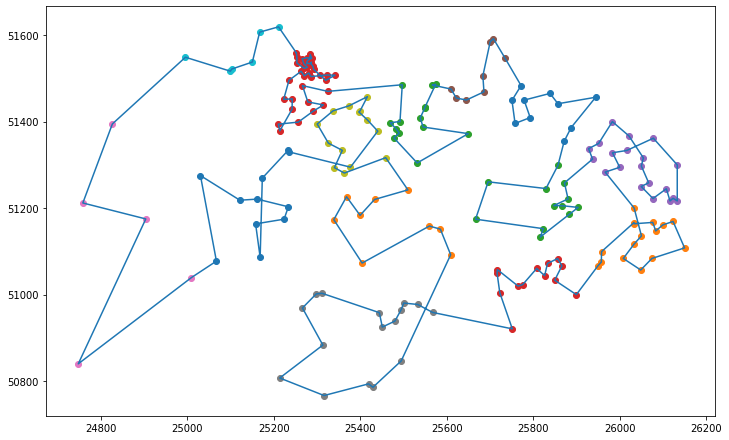

In [22]:
plot_result(hof[0],plot_cities=True, plot_cent_path=False, plot_clust_path=False, plot_individual=True)